# S&P500 Analysis

In [1]:
import json

import pandas as pd
import plotly.graph_objects as go
from tabulate import tabulate

## Load Data

- The Daily Change data is generated and saved to `sp500_daily_change.csv` with the column names being the stock tickers and the index being the date.
- The Correlation Matrix is generated and saved to `sp500_correlation_matrix.csv` with the column names and index being the stock tickers.
- The Market Capitalization data is loaded from `sp500_market_caps.json` with the keys being the stock tickers and the values being the market capitalization.

> Code to generate and save the data is commented out as it is not necessary to run it again. It is more efficient to load the data from the CSV files.

In [2]:
# Generate the daily change DataFrame
# daily_change_df = generate_daily_change_df()

# Save the DataFrame to a CSV file
# daily_change_df.to_csv("sp500_daily_change.csv")

# Load the DataFrame from the CSV file
daily_change_df = pd.read_csv("sp500_daily_change.csv", index_col=0)

In [3]:
# Calculate the correlation between columns
# correlation_matrix = daily_change_df.corr()

# Save the correlation matrix to a CSV file
# correlation_matrix.to_csv("sp500_correlation_matrix.csv")

# Load the correlation matrix from the CSV file
correlation_matrix = pd.read_csv("sp500_correlation_matrix.csv", index_col=0)

In [4]:
# Load the market cap data
with open("sp500_market_caps.json", "r") as f:
    market_caps = json.load(f)

## Preprocessing

The _S&P 500_ has 503 stocks, which is an odd number and hard (or impossible) to place on an evenly sized grid. Therefore, we will remove 3 of the smallest stocks to make the grid a nice round number (500 = 20 * 25).

In [5]:
# Remove 3 of the smallest stocks to make the grid a nice round number (500 = 20 * 25)
smallest_stocks = sorted(market_caps, key=market_caps.get)[:3]
print("Removing the following stocks from the dataset to leave a nice round number of 500: ", smallest_stocks)

# Remove the smallest stocks from the daily_change_df and correlation_matrix DataFrames
daily_change_df.drop(columns=smallest_stocks, inplace=True)
correlation_matrix.drop(index=smallest_stocks, columns=smallest_stocks, inplace=True)

Removing the following stocks from the dataset to leave a nice round number of 500:  ['FRC', 'LNC', 'DISH']


## Plot the data

The correlation matrix is a symmetric matrix with 1s on the diagonal.
The values in the matrix represent the correlation between the stocks.
The higher the value, the more correlated the stocks are.
The lower the value, the less correlated the stocks are.

The following plot shows the correlation matrix as a heatmap.
It helps visualize the correlation between the 500 stocks.
It also reveals the complex nature and task of placing the stocks on a grid.

In [6]:
# Create a simple heatmap of the correlation matrix using Plotly
fig = go.Figure(
    data=go.Heatmap(
        z=correlation_matrix.values,
        x=list(correlation_matrix.columns),
        y=list(correlation_matrix.index),
        colorscale="Viridis",
        showscale=True,
    )
)

# Show the plot
fig.show()

## Grid Placement Strategy

In [7]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster

### 1. Hierarchical Clustering

The first step is to perform hierarchical clustering on the correlation matrix.
The result is a dendrogram, which is a tree diagram that shows the hierarchical relationship between the stocks.

#### What is hierarchical clustering?

Hierarchical clustering is a method of cluster analysis that builds a hierarchy of clusters.
It begins with each stock in its own cluster.
Then, it repeatedly merges the two most similar clusters until only one cluster remains.

#### What is a dendrogram?

A dendrogram is a tree diagram that shows the hierarchical relationship between objects.
It can be used to visualize the clusters at a given level of granularity.

The following dendrogram shows the hierarchical clustering on 28 major cities based on their distances.

![Dendrogram of Large Cities](https://www.data-to-viz.com/graph/dendrogram_files/figure-html/unnamed-chunk-3-1.png)

1. Calculate the distance matrix from the correlation matrix.

This is done by subtracting the absolute correlation matrix from 1.
Then `scipy.spatial.distance.squareform` is used to convert the matrix to a condensed distance matrix.
This is a 1D array containing the upper triangular of the distance matrix.
This is the format required by `scipy.cluster.hierarchy.linkage`.


2. Perform hierarchical clustering on the distance matrix.

Then, `scipy.cluster.hierarchy.linkage` is used to perform hierarchical clustering on the distance matrix.
We use the `ward` method, which is the Ward variance minimization algorithm.
It minimizes the sum of squared differences within all clusters.
It is a variance-minimizing approach and, in that sense, is similar to the k-means algorithm.
It tries to find clusters that are more compact and homogeneous compared to other clustering methods.

The result is a linkage matrix, which is a matrix that encodes the hierarchical clustering.
It is a 2D array with 4 columns and `n - 1` rows, where `n` is the number of stocks.
Each row represents a merge: `[stock1, stock2, distance, number of stocks in the cluster]`.

In [8]:
distances = squareform(1 - correlation_matrix.abs())
linkage_matrix = linkage(distances, method='ward')

#### Visualize the dendrogram of the linkage matrix.

Note: Considering there are 500 stocks, the dendrogram is very large and hard to visualize. However, it can help reveal the hierarchical relationship between the stocks.

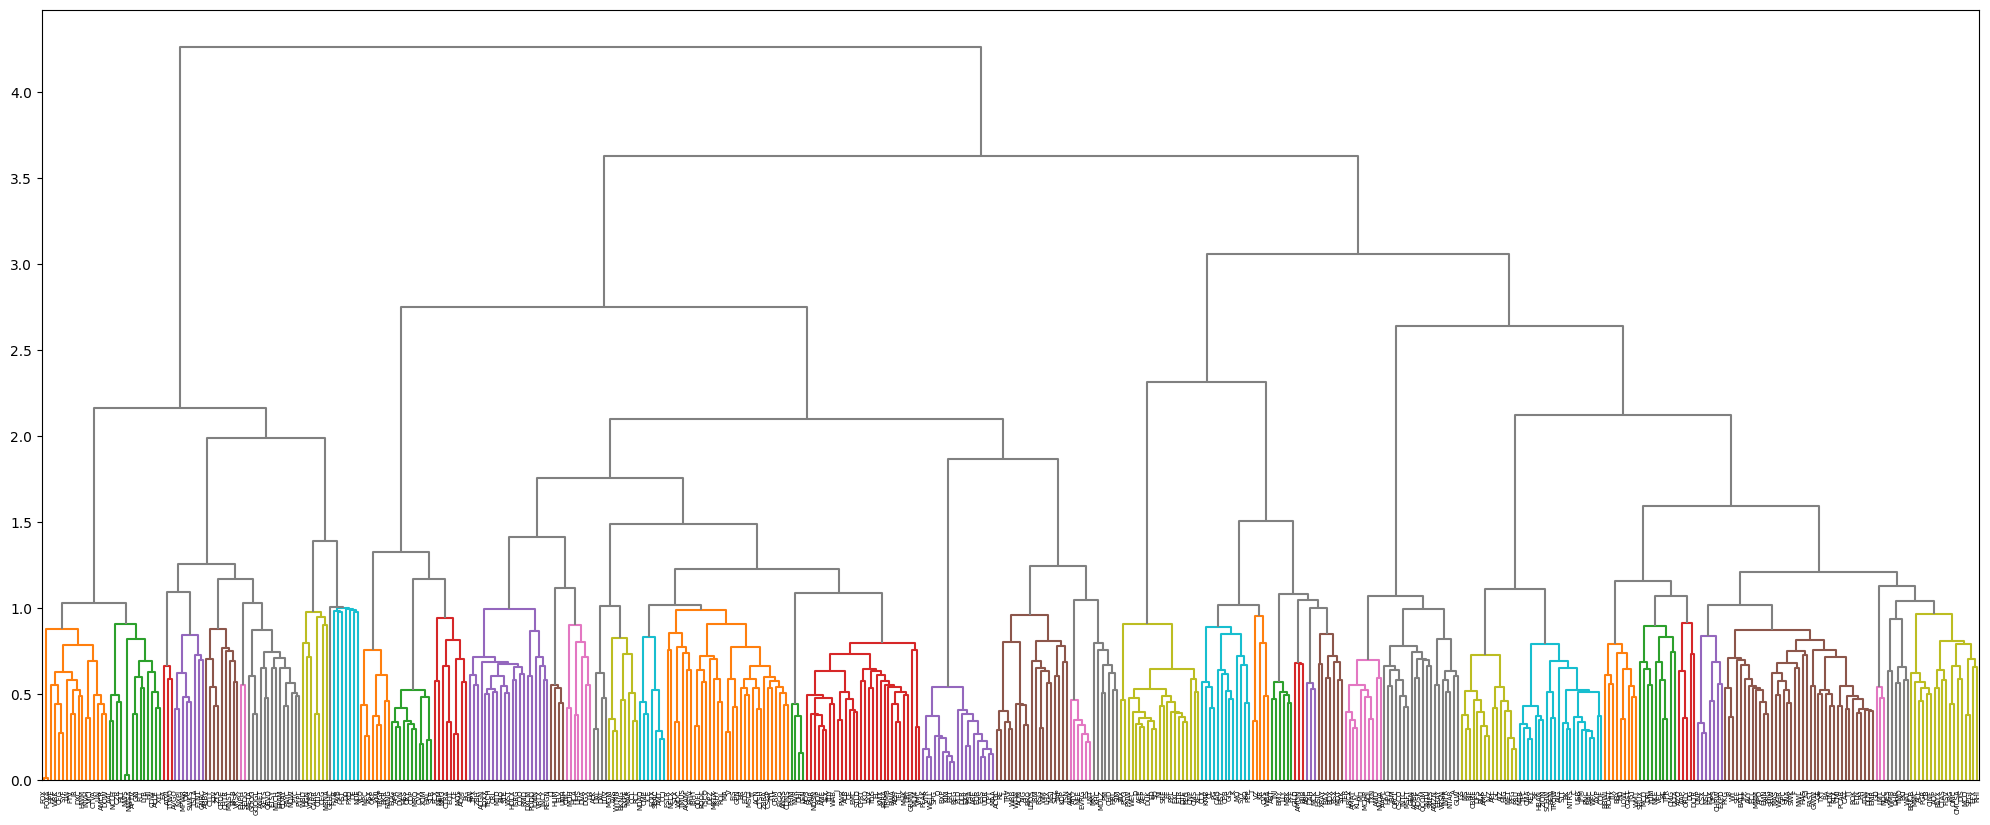

In [9]:
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(25, 10))
sp500_dn = dendrogram(linkage_matrix, labels=correlation_matrix.index, orientation='top', color_threshold=1, above_threshold_color='grey')
plt.show()

### 2. Cut the dendrogram at a given distance.

To form the clusters, we cut the dendrogram at a given distance.
This is done by using `scipy.cluster.hierarchy.fcluster` to extract the clusters from the linkage matrix.
The `criterion` parameter is set to `maxclust` to specify the maximum number of clusters through the `t` parameter.

#### Calculating the best `t` value using sklearn's Silhouette Score

The Silhouette Score is a measure of how similar an object is to its own cluster compared to other clusters.
The score ranges from -1 to 1.
The higher the score, the better the clustering.

We will test different values of `t` between 5 and 20 and calculate the Silhouette Score for each value.
The value of `t` with the highest Silhouette Score will be used to cut the dendrogram.

In [10]:
from sklearn.metrics import silhouette_score
from scipy.stats import variation

Best t: 16, with combined score: 0.02205576907292602


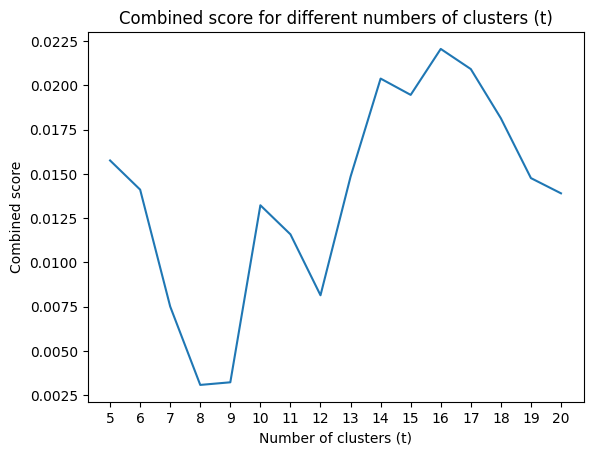

In [11]:
min_t = 5
max_t = 21  # 20 but we want to include 20 in the range so we add 1

# Convert the correlation matrix to a distance matrix
distance_matrix = 1 - correlation_matrix.abs()
np.fill_diagonal(distance_matrix.values, 0)

def combined_metric(distance_matrix, clusters):
    silhouette_avg = silhouette_score(distance_matrix, clusters, metric='precomputed')
    cluster_sizes = np.bincount(clusters)
    cv = variation(cluster_sizes)
    
    return silhouette_avg * (1 - cv)

best_t = 5
best_score = -1
scores = []

for t in range(min_t, max_t):
    clusters = fcluster(linkage_matrix, t=t, criterion='maxclust')
    combined_score = combined_metric(distance_matrix, clusters)
    scores.append(combined_score)
    
    if combined_score > best_score:
        best_score = combined_score
        best_t = t

print(f"Best t: {best_t}, with combined score: {best_score}")

# Plot the combined scores
plt.plot(range(min_t, max_t), scores)
plt.xticks(range(min_t, max_t))
plt.xlabel('Number of clusters (t)')
plt.ylabel('Combined score')
plt.title('Combined score for different numbers of clusters (t)')
plt.show()



In [12]:
clusters = fcluster(linkage_matrix, t=best_t, criterion='maxclust')

In [13]:
unique_clusters = np.unique(clusters)
cluster_sizes = []

for cluster_id in unique_clusters:
    cluster_stocks = list(correlation_matrix.index[clusters == cluster_id])
    cluster_size = len(cluster_stocks)
    cluster_sizes.append(cluster_size)
    print(f"Cluster {cluster_id} contains the following {cluster_size} tickers:")
    print(cluster_stocks)
    print()

# Print cluster statistics
print(f"Total number of clusters: {len(unique_clusters)}")
print(f"Minimum number of stocks per cluster: {min(cluster_sizes)}")
print(f"Maximum number of stocks per cluster: {max(cluster_sizes)}")
print(f"Average number of stocks per cluster: {np.mean(cluster_sizes):.2f}")
print(f"Median number of stocks per cluster: {np.median(cluster_sizes)}")
print(f"Standard deviation of the number of stocks per cluster: {np.std(cluster_sizes):.2f}")


Cluster 1 contains the following 31 tickers:
['AAL', 'ALLE', 'AMCR', 'APTV', 'CDW', 'CFG', 'CTVA', 'CZR', 'DOW', 'DXC', 'FLT', 'FOX', 'FOXA', 'FTV', 'GM', 'HII', 'HLT', 'HPE', 'HWM', 'INVH', 'IR', 'LIN', 'LW', 'LYB', 'NCLH', 'NWS', 'NWSA', 'SYF', 'VICI', 'WRK', 'XYL']

Cluster 2 contains the following 36 tickers:
['ABBV', 'ANET', 'ATVI', 'AVGO', 'BF-B', 'CBOE', 'CDAY', 'CHTR', 'CTLT', 'EA', 'ENPH', 'EPAM', 'ETSY', 'FTNT', 'GNRC', 'GOOG', 'GOOGL', 'IQV', 'KEYS', 'META', 'MNST', 'MPWR', 'MTCH', 'NOW', 'NXPI', 'ON', 'PAYC', 'PTC', 'PYPL', 'QRVO', 'SEDG', 'SWKS', 'TSLA', 'TTWO', 'VRSK', 'ZTS']

Cluster 3 contains the following 15 tickers:
['AVB', 'CARR', 'CEG', 'DD', 'DE', 'FITB', 'GEHC', 'HST', 'MRNA', 'NUE', 'OGN', 'OTIS', 'PXD', 'VTRS', 'WBD']

Cluster 4 contains the following 28 tickers:
['ADM', 'APA', 'BG', 'BKR', 'CF', 'COP', 'CTRA', 'CVX', 'DVN', 'EOG', 'EQT', 'FANG', 'FCX', 'HAL', 'HES', 'KMI', 'MOS', 'MPC', 'MRO', 'NEM', 'NRG', 'OKE', 'OXY', 'PSX', 'SLB', 'TRGP', 'VLO', 'XOM']

Cl

This clustering algorithm works almost too perfectly.
While the clustering algorithm was  perfrly provided data derivced from just intraday performance, it does an excellent job to group together stocks not just with similar performance, but also industries and sectors together.
While it is assumed that stocks in the same sector perform similarly, this clustering algorithm confirms this assumption in an unbiased manner.

Here are some examples demonstrating how good the clusters are:
- Cluster 7 includes exclusively travel related stocks: from airlines (AAL, ALK, and DAL) to cruises (CCL and RCL) and even hotels (MAR, MGM, and WYNN) to booking sites (BKNG and EXPE).
- Cluster 13 includes a lot of tech stocks from AAPL, ADBE, MSFT , and NVD to older tech companies like IBM, INTC, MU, ORCL, and TXN.
- Cluster 14 includes most of the banking and financial stocks from large banks like JPM, C, BAC, and WFC to regional banks like RF, RJF, and ZION.

Overall, the clusters are very good and the algorithm does an excellent job to group together stocks with similar performance, industries, and sectors.


### 3. Using Market Capitalization as weights

We are choosing Market Capitalization as the weights for the stocks.
Because we are analyzing an Index (S&P 500), we want to give more weight to the larger stocks as they have a larger impact on the index's performance.

In [14]:
market_caps_series = pd.Series(market_caps)
weights = market_caps_series / market_caps_series.sum()

In [15]:
# Step 4: Create force-directed graph layout
G = nx.Graph()

for i, stock in enumerate(correlation_matrix.columns):
    G.add_node(stock, cluster=clusters[i], weight=weights[i])

for i, stock1 in enumerate(correlation_matrix.columns):
    for j, stock2 in enumerate(correlation_matrix.columns):
        if i < j:
            G.add_edge(stock1, stock2, weight=1 - correlation_matrix.loc[stock1, stock2])

pos = nx.spring_layout(G, seed=42, weight='weight', k=0.5, iterations=100)

In [16]:
def find_nearest_empty_cell(x, y, grid):
    """
    Find the nearest empty cell in a clockwise spiral pattern starting from (x, y).
    """
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    direction_index = 0
    steps_same_direction = 1
    steps_left_same_direction = 1
    grid_size_x, grid_size_y = len(grid), len(grid[0])

    while True:
        if 0 <= x < grid_size_x and 0 <= y < grid_size_y:
            if grid[x][y] is None:
                return x, y
        
        x, y = x + directions[direction_index][0], y + directions[direction_index][1]
        steps_left_same_direction -= 1

        if steps_left_same_direction == 0:
            direction_index = (direction_index + 1) % 4
            if direction_index % 2 == 0:
                steps_same_direction += 1
            steps_left_same_direction = steps_same_direction

In [18]:
# Step 5: Place stocks in the 20x25 grid
grid_positions = np.array([(i // 25, i % 25) for i in range(500)])
pos_df = pd.DataFrame(pos).T
pos_df['grid_x'] = pd.cut(pos_df[0], bins=np.linspace(0, 1, 21), labels=False, include_lowest=True)
pos_df['grid_y'] = pd.cut(pos_df[1], bins=np.linspace(0, 1, 26), labels=False, include_lowest=True)

# Check for NaN values and replace them with appropriate indices
pos_df.loc[pos_df['grid_x'].isna(), 'grid_x'] = 0
pos_df.loc[pos_df['grid_y'].isna(), 'grid_y'] = 0

# Convert 'grid_x' and 'grid_y' columns to integers using applymap()
pos_df = pos_df.applymap(lambda x: int(x))

# Place stocks in the 20x25 grid
grid = [[None for _ in range(25)] for _ in range(20)]

for stock, row in pos_df.iterrows():
    x, y = row['grid_x'], row['grid_y']
    if grid[x][y] is None:
        grid[x][y] = stock
    else:
        x, y = find_nearest_empty_cell(x, y, grid)
        grid[x][y] = stock

In [19]:
# Convert the grid into a DataFrame
grid_df = pd.DataFrame(grid)
tabulate(grid_df, tablefmt='html', headers='keys', showindex='always')

'<table>\n<thead>\n<tr><th style="text-align: right;">  </th><th>0    </th><th>1    </th><th>2    </th><th>3   </th><th>4   </th><th>5   </th><th>6   </th><th>7   </th><th>8   </th><th>9   </th><th>10  </th><th>11  </th><th>12  </th><th>13  </th><th>14  </th><th>15  </th><th>16  </th><th>17  </th><th>18  </th><th>19  </th><th>20  </th><th>21  </th><th>22  </th><th>23  </th><th>24  </th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;"> 0</td><td>AAP  </td><td>ACGL </td><td>ADSK </td><td>ALK </td><td>APTV</td><td>ANSS</td><td>ABBV</td><td>AAPL</td><td>AES </td><td>ABC </td><td>AKAM</td><td>BMY </td><td>CBRE</td><td>ACN </td><td>ELV </td><td>CB  </td><td>CME </td><td>CAT </td><td>A   </td><td>ECL </td><td>BAC </td><td>FDS </td><td>AMT </td><td>EXR </td><td>J   </td></tr>\n<tr><td style="text-align: right;"> 1</td><td>ADI  </td><td>ADM  </td><td>AIG  </td><td>AMCR</td><td>AVY </td><td>AXP </td><td>ATVI</td><td>AMZN</td><td>CHD </td><td>CCL </td><td>ALB </td><td>CI  </td><td>CSGP</td><td>COO </td><td>GIS </td><td>EQR </td><td>EOG </td><td>HAL </td><td>ES  </td><td>ICE </td><td>LYV </td><td>IDXX</td><td>GE  </td><td>IP  </td><td>MAA </td></tr>\n<tr><td style="text-align: right;"> 2</td><td>ALGN </td><td>AEP  </td><td>AJG  </td><td>AMD </td><td>AWK </td><td>BIIB</td><td>CARR</td><td>CL  </td><td>CSCO</td><td>CNC </td><td>BBY </td><td>CTVA</td><td>CTSH</td><td>EXC </td><td>HII </td><td>IFF </td><td>GNRC</td><td>IEX </td><td>LYB </td><td>OXY </td><td>PARA</td><td>PFG </td><td>PHM </td><td>GL  </td><td>PKG </td></tr>\n<tr><td style="text-align: right;"> 3</td><td>AEE  </td><td>ANET </td><td>APA  </td><td>AMP </td><td>AZO </td><td>BK  </td><td>CCI </td><td>CMI </td><td>CVX </td><td>CLX </td><td>DLR </td><td>FANG</td><td>DUK </td><td>FOXA</td><td>AMAT</td><td>ILMN</td><td>KMB </td><td>LIN </td><td>NKE </td><td>PCG </td><td>PFE </td><td>PCAR</td><td>RCL </td><td>RF  </td><td>PNC </td></tr>\n<tr><td style="text-align: right;"> 4</td><td>BG   </td><td>BAX  </td><td>AVB  </td><td>APH </td><td>BALL</td><td>BKR </td><td>CDNS</td><td>CMS </td><td>DD  </td><td>DGX </td><td>ETN </td><td>CTLT</td><td>FOX </td><td>ED  </td><td>HRL </td><td>INVH</td><td>MMM </td><td>MMC </td><td>NEE </td><td>PEAK</td><td>MAS </td><td>RMD </td><td>STZ </td><td>RTX </td><td>RJF </td></tr>\n<tr><td style="text-align: right;"> 5</td><td>AME  </td><td>BWA  </td><td>BKNG </td><td>CAG </td><td>BXP </td><td>BSX </td><td>CF  </td><td>COST</td><td>DE  </td><td>DXC </td><td>ETSY</td><td>FDX </td><td>GILD</td><td>HBAN</td><td>K   </td><td>ALLE</td><td>MO  </td><td>COP </td><td>NTAP</td><td>ADP </td><td>PGR </td><td>BR  </td><td>SWKS</td><td>SYY </td><td>TEL </td></tr>\n<tr><td style="text-align: right;"> 6</td><td>ADBE </td><td>BRO  </td><td>CBOE </td><td>AAL </td><td>CDAY</td><td>CEG </td><td>CHTR</td><td>CPB </td><td>DFS </td><td>EBAY</td><td>EVRG</td><td>FISV</td><td>HES </td><td>GD  </td><td>KLAC</td><td>LKQ </td><td>MSFT</td><td>MU  </td><td>OKE </td><td>PPG </td><td>PODD</td><td>SNPS</td><td>MA  </td><td>TPR </td><td>TT  </td></tr>\n<tr><td style="text-align: right;"> 7</td><td>AVGO </td><td>CNP  </td><td>CDW  </td><td>CTAS</td><td>CMG </td><td>D   </td><td>CSX </td><td>CPRT</td><td>DG  </td><td>EMR </td><td>EW  </td><td>CFG </td><td>HLT </td><td>BF-B</td><td>LDOS</td><td>LUV </td><td>LHX </td><td>NI  </td><td>DIS </td><td>PSX </td><td>GPN </td><td>TSCO</td><td>VFC </td><td>TYL </td><td>UNP </td></tr>\n<tr><td style="text-align: right;"> 8</td><td>AOS  </td><td>BDX  </td><td>CZR  </td><td>EA  </td><td>DLTR</td><td>DRI </td><td>DPZ </td><td>DVA </td><td>DHI </td><td>CVS </td><td>EXPE</td><td>FTNT</td><td>GRMN</td><td>HUM </td><td>IQV </td><td>MDLZ</td><td>HOLX</td><td>NUE </td><td>KMX </td><td>PYPL</td><td>ROK </td><td>TXN </td><td>VICI</td><td>VLO </td><td>VTR </td></tr>\n<tr><td style="text-align: right;"> 9</td><td>AMGN </td><td>CMCSA</td><td>DXCM </td><td>EIX </td><td>ESS </td><td>EPAM</td><td>DAL </td><td>EQT </td><td>EL  </td><td>ENPH</td><td>FAST</td><td>

In [20]:
# Save the grid as a CSV file
grid_df.to_csv('sp500_grid.csv', index=False)